In [1]:
# prerequisites
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from scipy.stats import norm
from keras.utils import to_categorical
from keras import metrics

Using TensorFlow backend.


In [2]:
def enc_fc(x_dim, n_hidden, z_dim):
    x = Input(shape=(x_dim,))
    x_encoded = Dense(n_hidden, activation='relu')(x)
    x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

    z_x_mu = Dense(z_dim)(x_encoded)
    z_x_log_var_sq = Dense(z_dim)(x_encoded)  
    enc = Model(x, [z_x_mu, z_x_log_var_sq, x_encoded], name='encoder')
    return enc

In [3]:
# sampling function
def sampling(args):
    z_x_mu, z_x_log_var_sq = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return z_x_mu + K.exp(z_x_log_var_sq) * eps

In [4]:
# decoder
def dec_fc(n_hidden, x_dim):
    z_latent = Input(shape=(z_dim,), name='z_sampling')
    z_decoded = Dense(n_hidden//2, activation='relu')(z_latent)
    z_decoded = Dense(n_hidden, activation='relu')(z_decoded)
    x_hat = Dense(x_dim, activation='sigmoid')(z_decoded)
    dec = Model(z_latent, x_hat, name='decoder')
    return  dec

In [5]:
def classify_layer(n_hidden, y_dim):
    x_encoded = Input(shape=(n_hidden//2,), name='x_encoded')
    logits = Dense(32, activation='relu')(x_encoded)
    y_prob = Dense(y_dim, activation='softmax')(logits)
    cl = Model(x_encoded, y_prob, name='classify_layer') 
    return cl

In [6]:
def descriminator(y_dim, z_dim, n_hidden):
    y = Input(shape=(y_dim,), name='y')
    z_y = Dense(n_hidden//2, activation='relu')(y)
    z_y = Dense(n_hidden, activation='relu')(z_y)

    z_y_mu = Dense(z_dim)(z_y)
    z_y_log_var_sq = Dense(z_dim)(z_y)
    des = Model(y, [z_y_mu, z_y_log_var_sq], name='descriminator')
    
    return des

In [120]:
# loss
def vanilla_vae_loss(x, x_hat, x_dim, z_x_mu, z_x_log_var_sq):
    reconstruction_loss = objectives.binary_crossentropy(x, x_hat) * x_dim
    kl_loss = 0.5 * K.sum(K.square(z_x_mu) + K.exp(z_x_log_var_sq) - z_x_log_var_sq - 1, axis = -1)
    return reconstruction_loss + kl_loss

def KL_Term(z_x_mu, z_x_log_var_sq, z_y_mu, z_y_log_var_sq):
    kl_loss = 0.5 * K.sum((K.square(z_x_mu-z_y_mu) + K.exp(z_x_log_var_sq))/(K.exp(z_y_log_var_sq) + 1e-10) + z_y_log_var_sq - z_x_log_var_sq - 1, axis = -1)
    return kl_loss

def CL_Err(y, y_prob):
    cl_loss = metrics.categorical_crossentropy(y, y_prob)
    return cl_loss

def Entropy(y_prob):
#     des_loss = metrics.categorical_crossentropy(y_prob, y_prob)
    des_loss = K.sum(y_prob * K.log(y_prob))
    return des_loss

def labeled_loss(x, x_hat, x_dim, y, y_prob, z_x_mu, z_x_log_var_sq, z_y_mu, z_y_log_var_sq):
    reconstruction_loss = objectives.binary_crossentropy(x, x_hat) * x_dim
    return reconstruction_loss + KL_Term(z_x_mu, z_x_log_var_sq, z_y_mu, z_y_log_var_sq) + CL_Err(y, y_prob)

def unlabeled_loss(x, x_hat, x_dim, y_prob, z_x_mu, z_x_log_var_sq, z_y_mu, z_y_log_var_sq):
        reconstruction_loss = objectives.binary_crossentropy(x, x_hat) * x_dim
        KL_z_x_z_y = KL_Term(z_x_mu, z_x_log_var_sq, z_y_mu, z_y_log_var_sq)
        H_y_x = Entropy(y_prob)
        return reconstruction_loss + KL_Term(z_x_mu, z_x_log_var_sq, z_y_mu, z_y_log_var_sq) + H_y_x

In [8]:
def vae(enc, dec, args):
    x_dim, y_dim, z_dim, n_hidden = args
    x = Input(shape=(x_dim,), name='x')
    mu, log_var, x_encoded = enc(x)
    z_sampled = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])
    x_hat = dec(z_sampled)

    vae = Model(x, x_hat)
    vae.add_loss(vae_loss(x, x_hat, x_shape, mu, log_var))
    vae.compile(optimizer='rmsprop')
    return vae

In [94]:
def MODEL_Labeled(enc, dec, cl, des, args):
    x_dim, y_dim, z_dim, n_hidden = args
    x = Input(shape=(x_dim,), name='x')
    y = Input(shape=(y_dim,), name='y')
    
    z_x_mu, z_x_log_var_sq, x_encoded = enc(x)
    y_prob = cl(x_encoded)
#     y_pred = K.one_hot( K.argmax(y_prob, axis=-1), num_classes = y_dim)
    z_y_mu, z_y_log_var_sq = des(y)
    
    z_sampled = Lambda(sampling, output_shape=(z_dim,))([z_x_mu, z_x_log_var_sq])
    x_hat = dec(z_sampled)

    model = Model([x,y], [x_hat,y_prob, z_y_mu, z_y_log_var_sq])
#     vae.add_loss(vanilla_vae_loss(x, x_hat, x_dim, z_x_mu, z_x_log_var_sq))
    model.add_loss(labeled_loss(x, x_hat, x_dim, y, y_prob, z_x_mu, z_x_log_var_sq, z_y_mu, z_y_log_var_sq))
    model.compile(optimizer='rmsprop')
    return model

In [95]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

y_tr, y_te = to_categorical(y_tr), to_categorical(y_te)
print(x_tr.shape, x_te.shape, y_tr.shape, y_te.shape)

# network parameters
batch_size, n_epoch = 100, 30
n_hidden, z_dim = 256, 2
x_dim = x_tr.shape[1]
y_dim = y_tr.shape[1]
args = [x_dim, y_dim, z_dim, n_hidden]

(60000, 784) (10000, 784) (60000, 10) (10000, 10)


In [96]:
# print("ENCODER:")
# enc = enc_fc(x_dim, n_hidden, z_dim)
# enc.summary()
# print("\n")
# print("DECODER:")
# dec = dec_fc(n_hidden, x_dim)
# dec.summary()
# print("\n")
# print("VAE:")
# vae = vae(enc,dec,args)
# vae.summary()

In [97]:
# # train
# vae.fit(x_tr,
#        shuffle=True,
#        epochs=n_epoch,
#        batch_size=batch_size,
#        validation_data=(x_te, None), verbose=1)

In [98]:
print("ENCODER:")
enc = enc_fc(x_dim, n_hidden, z_dim)
enc.summary()
print("\n")
print("DECODER:")
dec = dec_fc(n_hidden, x_dim)
dec.summary()
print("\n")
print("CLASSIFY_LAYER:")
cl = classify_layer(n_hidden, y_dim)
cl.summary()
print("\n")
print("DESCRIMINATOR:")
des = descriminator(y_dim, z_dim, n_hidden)
des.summary()
print("\n")

ENCODER:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_92 (Dense)                (None, 256)          200960      input_8[0][0]                    
__________________________________________________________________________________________________
dense_93 (Dense)                (None, 128)          32896       dense_92[0][0]                   
__________________________________________________________________________________________________
dense_94 (Dense)                (None, 2)            258         dense_93[0][0]                   
__________________________________________________________________________________________________
d

In [99]:
print("MODEL_LABELED:")
model_labeled = MODEL_Labeled(enc, dec, cl, des, args)
model_labeled.summary()

MODEL_LABELED:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 784)          0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 234372      x[0][0]                          
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 2)            0           encoder[1][0]                    
                                                                 encoder[1][1]                    
__________________________________________________________________________________________________
y (InputLayer)                  (None, 10)           0                                        

In [100]:
# train
model_labeled.fit([x_tr, y_tr],
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=([x_te, y_te], None), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 15s 255us/step - loss: 183.6221 - val_loss: 163.7335
Epoch 2/30
60000/60000 [==============================] - 16s 262us/step - loss: 159.2039 - val_loss: 153.9408
Epoch 3/30
60000/60000 [==============================] - 16s 262us/step - loss: 152.0062 - val_loss: 150.6251
Epoch 4/30
60000/60000 [==============================] - 16s 269us/step - loss: 148.6342 - val_loss: 146.8081
Epoch 5/30
60000/60000 [==============================] - 15s 249us/step - loss: 146.6205 - val_loss: 145.8814
Epoch 6/30
60000/60000 [==============================] - 16s 266us/step - loss: 145.1599 - val_loss: 144.8511
Epoch 7/30
60000/60000 [==============================] - 16s 273us/step - loss: 144.0708 - val_loss: 144.1265
Epoch 8/30
60000/60000 [==============================] - 15s 251us/step - loss: 143.0754 - val_loss: 142.5709
Epoch 9/30
60000/60000 [==============================] - 14s 

In [102]:
# # Plot of the digit classes in the latent space
# x_te_latent = enc.predict(x_te, batch_size=batch_size)[0]
# plt.figure(figsize=(6, 6))
# plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
# plt.colorbar()
# plt.show()

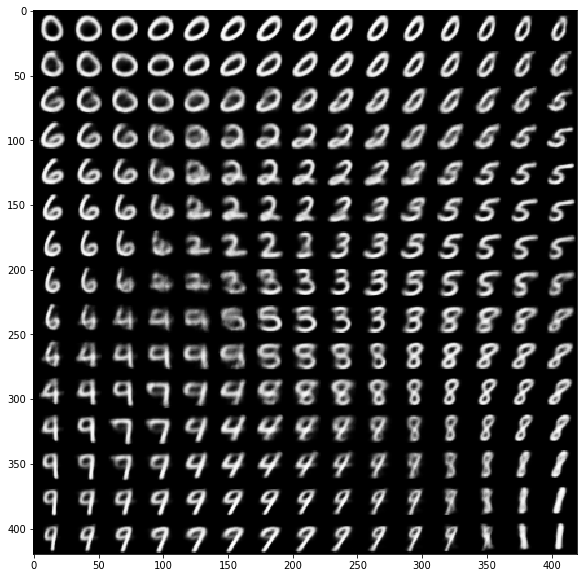

In [103]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = dec.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [104]:
def eval_Classifier(enc, cl, x_dim, x_te, y_te):
    x = Input(shape=(x_dim,), name='x')
    _,_, x_encoded = enc(x)
    y_prob = cl(x_encoded)
    eq_classifier = Model(x, y_prob)
    y_pred = eq_classifier.predict(x_te)
    print(y_pred[0])
    print(1 - np.nonzero(np.argmax(y_pred, axis = -1) - np.argmax(y_te, axis = -1))[0].shape[0] / y_pred.shape[0])

In [105]:
eval_Classifier(enc, cl, x_dim, x_te, y_te)

[1.55855109e-20 5.60755282e-08 4.15532384e-07 2.79993401e-07
 1.28007854e-10 7.88055385e-13 1.04412254e-17 9.99999285e-01
 2.45400325e-13 4.28139906e-08]
0.949


In [109]:
def eval_conditioned_generation(dec, des, y_dim, idx):
#     vv = np.array([8.2719943e-08,9.0058940e-03,1.0053888e-05,1.0401091e-03, 2.9097478e-06
# , 1.5751129e-03, 4.8512661e-06, 8.8430738e-01, 8.7304972e-02, 1.6748713e-02],)
#     vvv = np.array([1.55855109e-20, 5.60755282e-08, 4.15532384e-07, 2.79993401e-07,
#  1.28007854e-10, 7.88055385e-13, 1.04412254e-17, 9.99999285e-01,
#  2.45400325e-13, 4.28139906e-08])
#     z_7_mu_1, z_7_mu_2 = des.predict(np.array([vvv]))[0][idx]
#     z_7_log_var_sq_1, z_7_log_var_sq_2 = des.predict(np.array([vvv]))[1][idx]
    
    z_7_mu_1, z_7_mu_2 = des.predict(y_te)[0][idx]
    z_7_log_var_sq_1, z_7_log_var_sq_2 = des.predict(y_te)[1][idx]
    # display a 2D manifold of the digits
    
    n = 15 # figure with 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(0.05, 0.95, n)
    grid_y = np.linspace(0.05, 0.95, n)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_1 = norm(z_7_mu_1, np.sqrt(np.exp(z_7_log_var_sq_1))).ppf(xi)
            z_2 = norm(z_7_mu_2, np.sqrt(np.exp(z_7_log_var_sq_2))).ppf(yi)
            z_sample = np.array([[z_1, z_2]])
            x_decoded = dec.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

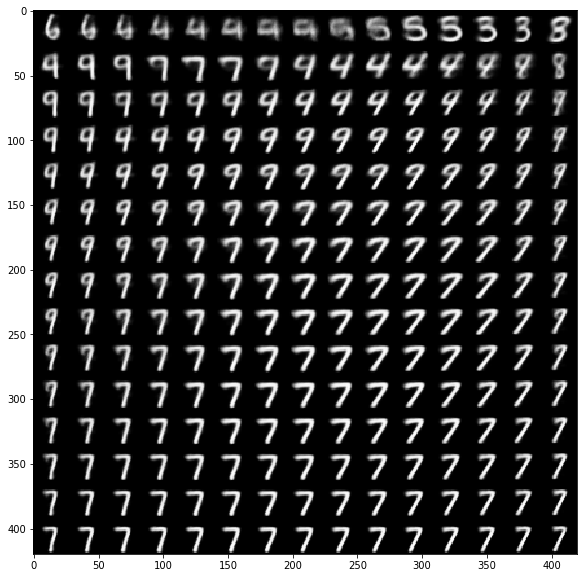

In [110]:
eval_conditioned_generation(dec, des, y_dim, 0)

In [121]:
def MODEL_Unlabeled(enc, dec, cl, des, args):
    x_dim, y_dim, z_dim, n_hidden = args
    x = Input(shape=(x_dim,), name='x')
    
    z_x_mu, z_x_log_var_sq, x_encoded = enc(x)
    y_prob = cl(x_encoded)
    z_y_mu, z_y_log_var_sq = des(y_prob)
    
    z_sampled = Lambda(sampling, output_shape=(z_dim,))([z_x_mu, z_x_log_var_sq])
    x_hat = dec(z_sampled)

    model = Model(x, [x_hat,y_prob, z_y_mu, z_y_log_var_sq])
#     vae.add_loss(vanilla_vae_loss(x, x_hat, x_dim, z_x_mu, z_x_log_var_sq))
    model.add_loss(unlabeled_loss(x, x_hat, x_dim, y_prob, z_x_mu, z_x_log_var_sq, z_y_mu, z_y_log_var_sq))
    model.compile(optimizer='rmsprop')
    return model

In [122]:
print("MODEL_UNLABELED:")
model_unlabeled = MODEL_Unlabeled(enc, dec, cl, des, args)
model_unlabeled.summary()

MODEL_UNLABELED:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 784)          0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 234372      x[0][0]                          
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 2)            0           encoder[5][0]                    
                                                                 encoder[5][1]                    
__________________________________________________________________________________________________
classify_layer (Model)          (None, 10)           4458        encoder[5][2]              

In [123]:
# train
model_labeled.fit([x_tr, y_tr],
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=([x_te, y_te], None), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 18s 293us/step - loss: 134.3133 - val_loss: 136.7236
Epoch 2/30
60000/60000 [==============================] - 12s 198us/step - loss: 134.1526 - val_loss: 137.2490
Epoch 3/30
60000/60000 [==============================] - 16s 272us/step - loss: 134.0304 - val_loss: 136.8202
Epoch 4/30
60000/60000 [==============================] - 17s 277us/step - loss: 133.8728 - val_loss: 136.6825
Epoch 5/30
60000/60000 [==============================] - 16s 262us/step - loss: 133.7884 - val_loss: 136.3889
Epoch 6/30
60000/60000 [==============================] - 18s 292us/step - loss: 133.6056 - val_loss: 136.1056
Epoch 7/30
60000/60000 [==============================] - 16s 271us/step - loss: 133.3898 - val_loss: 136.4976
Epoch 8/30
60000/60000 [==============================] - 16s 266us/step - loss: 133.2970 - val_loss: 136.4721
Epoch 9/30
60000/60000 [==============================] - 17s 

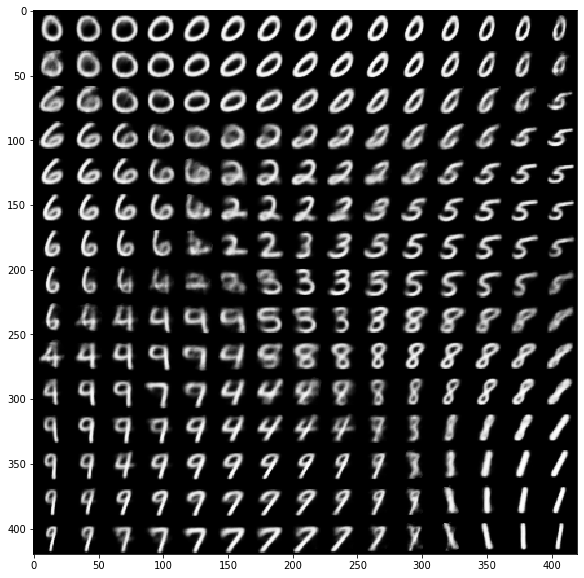

In [124]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = dec.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

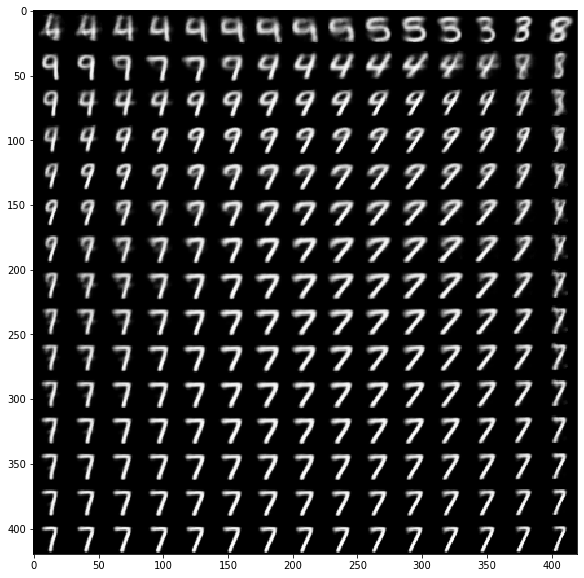

In [125]:
eval_conditioned_generation(dec, des, y_dim, 0)

In [126]:
eval_Classifier(enc, cl, x_dim, x_te, y_te)

[3.7211478e-27 9.9682825e-07 4.5680117e-08 7.9602262e-07 6.1813559e-08
 4.0390960e-13 3.1683836e-16 9.9997807e-01 5.8188033e-14 2.0068626e-05]
0.9448
